In [1]:
# Importing libraries:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import requests as rq
import tweepy as tw
import json as js
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import time as dt


#Read the first source Twitter data

In [3]:
twt_archive_dat= pd.read_csv('twitter-archive-enhanced.csv') 
twt_archive_dat.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [4]:
#Read the secind source image prediction

In [5]:
file_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_data = rq.get(file_url)

In [6]:
file_data

<Response [200]>

In [7]:
file_name = file_url.split('/')[-1]
file_name

'image-predictions.tsv'

In [8]:
image_prdctn = pd.read_csv(file_name,sep = '\t')

In [9]:
image_prdctn.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [10]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions

In [11]:
"""
consumer_key = '----'
consumer_secret = '----'
access_token = '---'
access_secret = '----'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)
 
tweet_ids = df_1.tweet_id.values
len(tweet_ids)
 
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
"""

'\nconsumer_key = \'----\'\nconsumer_secret = \'----\'\naccess_token = \'---\'\naccess_secret = \'----\'\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True)\n \ntweet_ids = df_1.tweet_id.values\nlen(tweet_ids)\n \ncount = 0\nfails_dict = {}\nstart = timer()\n# Save each tweet\'s returned JSON as a new line in a .txt file\nwith open(\'tweet_json.txt\', \'w\') as outfile:\n    \n    for tweet_id in tweet_ids:\n        count += 1\n        print(str(count) + ": " + str(tweet_id))\n        try:\n            tweet = api.get_status(tweet_id, tweet_mode=\'extended\')\n            print("Success")\n            json.dump(tweet._json, outfile)\n            outfile.write(\'\n\')\n        except tweepy.TweepError as e:\n            print("Fail")\n            fails_dict[tweet_id] = e\n            pass\nend = timer()\nprint(end - start)\nprint(fails_dict)\n'

Read tweet json data

In [12]:
tweet_jsn_df = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        tweet_jsn_df.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
retwet_favort_df = pd.DataFrame(tweet_jsn_df)
retwet_favort_df.head()

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


In [13]:
retwet_favort_df.shape

(2354, 3)

# Starting assess

## Visual assessment for  twt_archive_dat

In [14]:
twt_archive_dat

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


## Visual assessment image_prdctn

In [15]:
image_prdctn.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


Visual assessment for retwet_favort_df

In [16]:
retwet_favort_df.head()

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


# programmatically  assessing
twt_archive_dat
image_prdctn
retwet_favort_df

In [17]:
sum(twt_archive_dat.duplicated())
twt_archive_dat['tweet_id'].duplicated().sum()
print(twt_archive_dat.isnull().sum())
print()
print(twt_archive_dat.notnull().sum())

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

tweet_id                      2356
in_reply_to_status_id           78
in_reply_to_user_id             78
timestamp                     2356
source                        2356
text                          2356
retweeted_status_id            181
retweeted_status_user_id       181
retweeted_status_timestamp     181
expanded_urls                 2297
rating_numerator              2356
rating

In [18]:
twt_archive_dat.name[twt_archive_dat.name == 'None'].count()

745

In [19]:
twt_archive_dat.doggo[twt_archive_dat.doggo == 'None'].count()

2259

In [20]:
twt_archive_dat.floofer[twt_archive_dat.floofer == 'None'].count()

2346

In [21]:
twt_archive_dat.pupper[twt_archive_dat.pupper == 'None'].count()

2099

In [22]:
twt_archive_dat.puppo[twt_archive_dat.puppo == 'None'].count()

2326

In [23]:
twt_archive_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [24]:
dd = twt_archive_dat[5:13].query('rating_numerator > 13')

In [25]:
dd

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [26]:
image_prdctn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## image_prdctn assess

In [27]:
image_prdctn.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [28]:
sum(image_prdctn.duplicated())
image_prdctn['tweet_id'].duplicated().sum()
print(image_prdctn.isnull().sum())
print()
print(image_prdctn.notnull().sum())

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

tweet_id    2075
jpg_url     2075
img_num     2075
p1          2075
p1_conf     2075
p1_dog      2075
p2          2075
p2_conf     2075
p2_dog      2075
p3          2075
p3_conf     2075
p3_dog      2075
dtype: int64


In [29]:
retwet_favort_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [30]:
retwet_favort_df.head()

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


In [31]:
sum(retwet_favort_df.duplicated())
retwet_favort_df['tweet_id'].duplicated().sum()
print(retwet_favort_df.isnull().sum())
print()
print(retwet_favort_df.notnull().sum())

favorite_count    0
retweet_count     0
tweet_id          0
dtype: int64

favorite_count    2354
retweet_count     2354
tweet_id          2354
dtype: int64


# Assessment summary

# Quality asessment issues 

##### 1- The data has a tweet with no image
##### 2- The data are contained  reply tweets not original only  , The count of it = 78
##### 3- The data are contained  retweets is not original , The count of it is = 181
##### 4-Remove tweets from image prdctn which hasn’t orginal tweet
##### 5- I found that in image file columns not clear names
##### 6- The  name doggo   floofer   pupper  puppo columns  string 'None' values suppose  convert t be NaN
#### 7- timestamp on archive tweet type is not date must convert to date t
#### 8- Tweet ids type is int64 in all of files supposed be string



# Tidiness issues 

In [32]:
"""
1-To check if the tweet has an image or not you must check it in out file image-predictions not in the same file 
2-To get count of favorites you must link with another file using looping iteration to update the basic data tweet
3-To get count of retweet   you must link with another file using looping iteration to update the basic data tweet
4-in_reply_to_status_id and in_reply_to_user_id columns will not be needed after cleaneing not original tweet
5-retweeted_status_id , retweeted_status_user_id and retweeted_status_timestamp columns will not be needed after cleaneing not original tweet
6-The variables(doggo ,floofer,pupper and puppo) are the same values containt
"""

'\n1-To check if the tweet has an image or not you must check it in out file image-predictions not in the same file \n2-To get count of favorites you must link with another file using looping iteration to update the basic data tweet\n3-To get count of retweet   you must link with another file using looping iteration to update the basic data tweet\n4-in_reply_to_status_id and in_reply_to_user_id columns will not be needed after cleaneing not original tweet\n5-retweeted_status_id , retweeted_status_user_id and retweeted_status_timestamp columns will not be needed after cleaneing not original tweet\n6-The variables(doggo ,floofer,pupper and puppo) are the same values containt\n'

# Cleaning data
## Defien
- 1-Remove tweets replying rows from archive dataframe
- 2-Remove retweet  rows from archive dataframe
- 3-Drop (reply and retweeted) columns.
- 4-Replace variables(doggo ,floofer,pupper and puppo) values from 'None' to NaN
- 5-Remove rows which hasn’t image
- 6-Remove tweets from image prdctn which hasn’t orginal tweet
- 7-Merge tweet favorite count value with the original archive file by adding new column
- 8-Merge retweet count with the original archive file by adding new column

# change tweet id typ

In [33]:
twt_archive_dat['tweet_id'] = twt_archive_dat['tweet_id'].astype(str)
twt_archive_dat.info()
print('----------------------------------')
retwet_favort_df['tweet_id'] = retwet_favort_df['tweet_id'].astype(str)
retwet_favort_df.info()
print('----------------------------------')
image_prdctn['tweet_id'] = image_prdctn['tweet_id'].astype(str) 
retwet_favort_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

## 1-Remove tweets replying rows 
## 2-Remove retweet rows 
### Code


#### Get a copy of the basic data

In [34]:
main_df = twt_archive_dat.copy()
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

####  - Clean reply data
#####  The data count pefore cleaning = 2356 and reply count is 78

In [35]:
main_df.in_reply_to_status_id.notnull().sum()

78

In [36]:
main_df.shape

(2356, 17)

In [37]:
# Cleaning  action 
main_df = main_df[main_df.in_reply_to_status_id/main_df.in_reply_to_status_id != 1]

In [38]:
main_df.in_reply_to_status_id.notnull().sum()

0

#### Test after clean reply tweet data, There's 78 records are removed

In [39]:
main_df.shape 

(2278, 17)

####  - Clean retweeted  data retweeted_status_id
#####  The data count pefore cleaning = 2278

In [40]:
main_df.retweeted_status_id.notnull().sum()

181

In [41]:
# Cleaning  action 
main_df = main_df[main_df.retweeted_status_id/main_df.retweeted_status_id != 1]

#### Test after clean retweet data, There's 181 records are removed

In [42]:
main_df.retweeted_status_id.notnull().sum()

0

In [43]:
main_df.shape

(2097, 17)

## 3- Drop retweet and reply tweet columns

In [44]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(2), object(11

In [45]:
# Cleaning  action 
main_df.drop('retweeted_status_id', axis = 1 ,inplace =True)
main_df.drop('in_reply_to_status_id', axis = 1 ,inplace =True)
main_df.drop('in_reply_to_user_id', axis = 1 ,inplace =True)
main_df.drop('retweeted_status_user_id', axis = 1 ,inplace =True)
main_df.drop('retweeted_status_timestamp', axis = 1 ,inplace =True)

#### Test Drop (reply and retweeted) columns

In [46]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(2), object(10)
memory usage: 213.0+ KB


## 4-Replace variables(doggo ,floofer,pupper and puppo) values from 'None' to NaN
### Code

In [47]:
# Cleaning  action 
main_df.doggo =main_df.doggo.str.replace('None' ,'')
main_df.floofer =main_df.floofer.str.replace('None' ,'')
main_df.pupper =main_df.pupper.str.replace('None' ,'')
main_df.puppo =main_df.puppo.str.replace('None' ,'')


## Test Replace variables values

In [48]:
main_df[main_df.doggo == 'Non']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [49]:
main_df[main_df.floofer == 'Non']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [50]:
main_df[main_df.pupper == 'Non']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [51]:
main_df[main_df.puppo == 'Non']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [52]:
image_prdctn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


# 5- Rename columns in image file are not cleared names

In [53]:
image_prdctn.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [54]:
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
image_prdctn.columns = cols

In [55]:
image_prdctn.head(2)

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,breed_1,prediction_2,confidence_2,breed_2,prediction_3,confidence_3,breed_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


# 6 -Remove rows which hasn’t image
## code

In [56]:
tweet_id_with_img = list(image_prdctn.tweet_id.unique())
print(len(tweet_id_with_img) == image_prdctn.tweet_id.isin(tweet_id_with_img).sum())
main_df.shape

True


(2097, 12)

In [57]:
# Cleaning  action 
main_df2 = main_df[main_df.tweet_id.isin(tweet_id_with_img)]

### Test

In [58]:
main_df2.shape

(1971, 12)

## 7 -Remove tweets from image prdctn which hasn’t orginal tweet
### Code

In [59]:
tweet_id_orginal = list(main_df2.tweet_id.unique())
print(len(tweet_id_orginal) == main_df2.tweet_id.isin(tweet_id_with_img).sum())
main_df2.shape

True


(1971, 12)

In [60]:
# Cleaning  action 
image_prdctn_clean = image_prdctn[image_prdctn.tweet_id.isin(tweet_id_orginal)]

In [61]:
image_prdctn_clean.shape

(1971, 12)

## 8-Mearge favorites and retweets counts to main data frame
### code


In [62]:
main_df_2 = pd.merge(main_df2, retwet_favort_df, how = 'left', on = 'tweet_id')

# merging

### Test 

In [63]:
main_df_2.shape

(1971, 14)

In [64]:
main_df_2.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,,39467,8853
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,,33819,6514


In [65]:
main_df_2 = pd.merge(main_df_2,image_prdctn_clean , how = 'left', on = 'tweet_id')  

In [66]:
main_df_2.shape

(1971, 25)

In [67]:
main_df_2.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,prediction_1,confidence_1,breed_1,prediction_2,confidence_2,breed_2,prediction_3,confidence_3,breed_3
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


# 9- Create dog stage helful column

In [68]:
main_df_2['dog_stage'] = main_df_2['doggo'].fillna('')+main_df_2['floofer'].fillna('')+main_df_2['pupper'].fillna('')+main_df_2['puppo'].fillna('')

In [69]:
main_df_2.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,prediction_1,confidence_1,breed_1,prediction_2,confidence_2,breed_2,prediction_3,confidence_3,breed_3,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,


In [70]:
main_df_2['dog_stage'] = main_df_2['dog_stage'].replace({"doggofloofer": "doggo - floofer"})
main_df_2['dog_stage'] = main_df_2['dog_stage'].replace({"doggopupper": "doggo - pupper"})
main_df_2['dog_stage'] = main_df_2['dog_stage'].replace({"doggopuppo": "doggo - puppo"})

In [71]:
main_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 26 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
favorite_count        1971 non-null int64
retweet_count         1971 non-null int64
jpg_url               1971 non-null object
img_num               1971 non-null int64
prediction_1          1971 non-null object
confidence_1          1971 non-null float64
breed_1               1971 non-null bool
prediction_2          1971 non-null object
confidence_2          1971 non-null flo

# 10- timestamp on archive tweet type is not date must convert to date 

In [72]:
main_df_2['timestamp'] = pd.to_datetime(main_df_2['timestamp'])
main_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 26 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
favorite_count        1971 non-null int64
retweet_count         1971 non-null int64
jpg_url               1971 non-null object
img_num               1971 non-null int64
prediction_1          1971 non-null object
confidence_1          1971 non-null float64
breed_1               1971 non-null bool
prediction_2          1971 non-null object
confidence_2          1971 non-

In [73]:
main_df_2.to_csv('twitter_archive_master.csv', index=False)
main_df_2.to_excel('twitter_archive_master.xlsx', index=False)

# Storing and Acting on Wrangled Data

In [74]:
df = pd.read_csv('twitter_archive_master.csv')

In [75]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 26 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 73 non-null object
floofer               8 non-null object
pupper                209 non-null object
puppo                 23 non-null object
favorite_count        1971 non-null int64
retweet_count         1971 non-null int64
jpg_url               1971 non-null object
img_num               1971 non-null int64
prediction_1          1971 non-null object
confidence_1          1971 non-null float64
breed_1               1971 non-null bool
prediction_2          1971 non-null object
confidence_2          1971 non-null floa

In [77]:
df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,prediction_1,confidence_1,breed_1,prediction_2,confidence_2,breed_2,prediction_3,confidence_3,breed_3,dog_stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,NaN


In [78]:
df2 = df.groupby(by="dog_stage").sum() 

In [79]:
df2

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,confidence_1,breed_1,confidence_2,breed_2,confidence_3,breed_3
dog_stage,,,,,,,,,,,,
doggo,5.024919e+19,749.0,630.0,1219452.0,448919.0,81.0,36.354634,48.0,9.912485,49.0,3.911219,45.0
doggo - floofer,8.540102e+17,11.0,10.0,17169.0,3433.0,1.0,0.354733,1.0,0.177538,1.0,0.131706,1.0
doggo - pupper,6.198193e+18,88.0,80.0,105759.0,35178.0,9.0,6.604339,7.0,0.729146,6.0,0.238942,5.0
doggo - puppo,8.558515e+17,13.0,10.0,47844.0,19196.0,1.0,0.321676,1.0,0.115138,1.0,0.096100,1.0
floofer,5.365860e+18,84.0,70.0,92442.0,34781.0,8.0,4.264427,7.0,1.087233,7.0,0.335976,6.0
pupper,1.444591e+20,2154.0,2010.0,1457356.0,478883.0,252.0,121.772227,144.0,26.213574,147.0,11.236308,142.0
puppo,1.779792e+19,264.0,220.0,474806.0,142427.0,32.0,15.890438,19.0,2.980292,20.0,0.961426,21.0


In [80]:
df2 = df.groupby(by="dog_stage").sum() 

In [81]:
df2

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,confidence_1,breed_1,confidence_2,breed_2,confidence_3,breed_3
dog_stage,,,,,,,,,,,,
doggo,5.024919e+19,749.0,630.0,1219452.0,448919.0,81.0,36.354634,48.0,9.912485,49.0,3.911219,45.0
doggo - floofer,8.540102e+17,11.0,10.0,17169.0,3433.0,1.0,0.354733,1.0,0.177538,1.0,0.131706,1.0
doggo - pupper,6.198193e+18,88.0,80.0,105759.0,35178.0,9.0,6.604339,7.0,0.729146,6.0,0.238942,5.0
doggo - puppo,8.558515e+17,13.0,10.0,47844.0,19196.0,1.0,0.321676,1.0,0.115138,1.0,0.096100,1.0
floofer,5.365860e+18,84.0,70.0,92442.0,34781.0,8.0,4.264427,7.0,1.087233,7.0,0.335976,6.0
pupper,1.444591e+20,2154.0,2010.0,1457356.0,478883.0,252.0,121.772227,144.0,26.213574,147.0,11.236308,142.0
puppo,1.779792e+19,264.0,220.0,474806.0,142427.0,32.0,15.890438,19.0,2.980292,20.0,0.961426,21.0


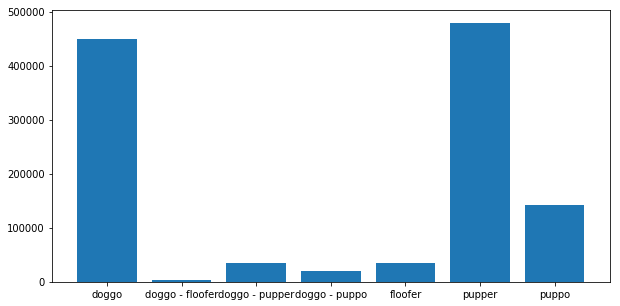

In [82]:
f, ax = plt.subplots(figsize=(10,5))
plt.bar(['doggo','doggo - floofer','doggo - pupper','doggo - puppo','floofer','pupper','puppo'],df2.retweet_count)
ax.legend(fontsize = 20)
plt.show()

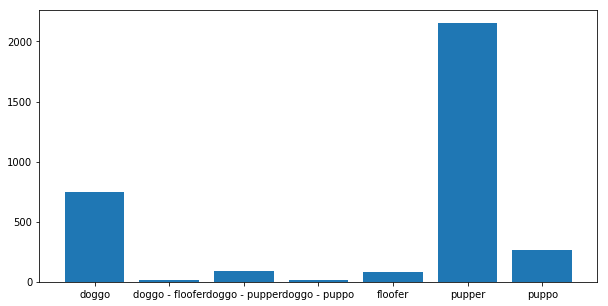

In [83]:
f, ax = plt.subplots(figsize=(10,5))
plt.bar(['doggo','doggo - floofer','doggo - pupper','doggo - puppo','floofer','pupper','puppo'],df2.rating_numerator)
ax.legend(fontsize = 20)
plt.show()

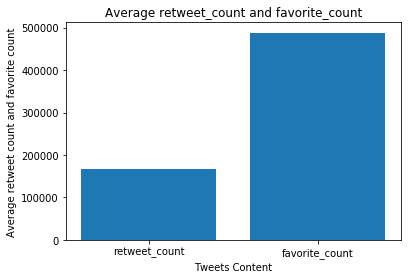

In [84]:
mean_quality_low = df2['retweet_count'].mean()
mean_quality_high = df2['favorite_count'].mean()
locations = [1, 2]
heights = [mean_quality_low, mean_quality_high]
labels = ['retweet_count', 'favorite_count']

plt.bar(locations, heights, tick_label=labels)
plt.title('Average retweet_count and favorite_count')
plt.xlabel('Tweets Content')
plt.ylabel('Average retweet count and favorite count');

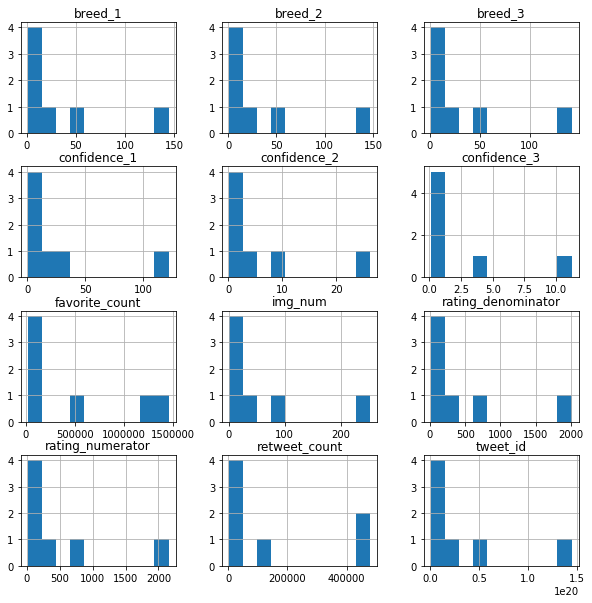

In [85]:
# explore data 
df2.hist(figsize=(10, 10));

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 26 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 73 non-null object
floofer               8 non-null object
pupper                209 non-null object
puppo                 23 non-null object
favorite_count        1971 non-null int64
retweet_count         1971 non-null int64
jpg_url               1971 non-null object
img_num               1971 non-null int64
prediction_1          1971 non-null object
confidence_1          1971 non-null float64
breed_1               1971 non-null bool
prediction_2          1971 non-null object
confidence_2          1971 non-null floa

In [87]:
df3 = df.groupby(['retweet_count', 'favorite_count','timestamp']).mean()

In [88]:
df3

tweet_id  \
retweet_count favorite_count timestamp                                 
16            81             2015-11-16 03:55:04  666102155909144576   
23            107            2015-11-17 02:46:43  666447344410484736   
34            264            2015-11-22 04:56:43  668291999406125056   
37            108            2015-11-16 14:57:41  666268910803644416   
41            111            2015-11-16 00:24:50  666049248165822464   
44            113            2015-11-17 00:06:54  666407126856765440   
45            211            2015-11-23 02:41:01  668620235289837568   
              267            2015-11-28 18:50:15  670676092097810432   
47            121            2015-11-16 02:38:37  666082916733198336   
              128            2015-11-15 23:21:54  666033412701032448   
48            129            2015-11-17 00:53:15  666418789513326592   
              132            2015-11-15 23:05:30  666029285002620928   
51            175            2015-11-18 19:43:11  667065535570550784   
              196            2015-11-17 18:56:35  666691418707132416   
52            131            2015-11-17 02:06:42  666437273139982336   
54            170            2015-11-17 02:00:15  666435652385423360   
              198            2015-11-18 18:17:59  667044094246576128   
57            227            2015-11-18 19:29:52  667062181243039744   
58            200            2015-11-19 03:10:02  667177989038297088   
59            222            2015-11-21 04:00:28  667915453470232576   
60            136            2015-11-16 00:30:50  666050758794694656   
              211            2015-11-19 17:26:08  667393430834667520   
61            115            2015-11-16 01:01:59  666058600524156928   
              243            2015-11-20 18:35:10  667773195014021120   
              248            2015-11-25 17:25:28  669567591774625792   
62            265            2015-11-22 23:12:44  668567822092664832   
63            284            2015-11-23 23:23:31  668932921458302976   
64            250            2015-11-26 16:59:01  669923323644657664   
65            317            2015-11-26 20:04:40  669970042633789440   
66            203            2015-11-19 21:32:34  667455448082227200   
...                                                              ...   
17919         35400          2016-08-06 21:20:40  762035686371364864   
18285         49720          2015-11-19 01:27:25  667152164079423488   
18497         33345          2016-09-15 00:36:55  776218204058357760   
18627         58302          2017-02-07 17:00:28  829011960981237760   
18781         69871          2017-07-19 00:47:34  887473957103951872   
18876         49774          2016-11-30 18:16:08  804026241225523200   
18963         35178          2015-12-11 16:40:19  675354435921575936   
19196         47844          2017-04-22 18:31:02  855851453814013952   
19297         73397          2017-02-12 01:04:29  830583320585068544   
19669         56413          2017-01-29 02:44:34  825535076884762624   
20500         35865          2016-03-20 23:23:54  711694788429553664   
21324         34856          2015-12-23 00:45:35  679462823135686656   
21794         49960          2017-01-11 02:21:57  819006400881917952   
21840         66437          2017-05-10 00:08:34  862096992088072192   
24319         43694          2016-06-05 19:47:03  739544079319588864   
25661         75193          2017-05-02 00:04:57  859196978902773760   
27680         85011          2017-06-01 20:18:38  870374049280663552   
27728         55683          2016-11-07 03:14:10  795464331001561088   
30742         61794          2015-12-20 02:20:55  678399652199309312   
31314         57622          2017-01-07 20:18:46  817827839487737856   
31989         67100          2015-12-14 01:58:31  676219687039057920   
32883         106827         2017-05-22 00:28:40  866450705531457536   
33421         55016          2016-08-05 21:19:27  761672994376806400   
37911         75639         

In [89]:
df3 = df.groupby(['retweet_count', 'dog_stage','timestamp']).sum()
df3

,,,tweet_id,rating_numerator,rating_denominator,favorite_count,img_num,confidence_1,breed_1,confidence_2,breed_2,confidence_3,breed_3
retweet_count,dog_stage,timestamp,,,,,,,,,,,
103,pupper,2015-12-09 23:47:22,674737130913071104,10,10,693,1,0.948537,True,0.014310,True,0.008120,True
137,pupper,2015-12-03 18:23:34,672481316919734272,12,10,757,1,0.599454,True,0.106227,True,0.094465,True
252,pupper,2015-12-10 17:37:00,675006312288268288,10,10,1057,1,0.654697,True,0.043389,False,0.042848,True
265,pupper,2015-12-07 00:12:23,673656262056419328,10,10,769,1,0.700625,True,0.094698,True,0.057559,True
314,pupper,2015-12-05 04:00:04,672988786805112832,10,10,1039,1,0.836632,True,0.073900,True,0.038160,True
338,pupper,2015-12-06 04:49:31,673363615379013632,11,10,1088,1,0.193431,False,0.123827,False,0.111177,False
388,pupper,2015-12-12 18:13:51,675740360753160192,12,10,1257,1,0.800495,True,0.097756,True,0.068415,True
391,pupper,2015-12-05 02:46:02,672970152493887488,7,10,1019,1,0.340154,False,0.139698,False,0.058034,False
393,pupper,2015-12-09 04:36:06,674447403907457024,10,10,1137,1,0.409909,True,0.244649,True,0.074820,True


In [90]:
df['month'] = df['timestamp'].dt.month

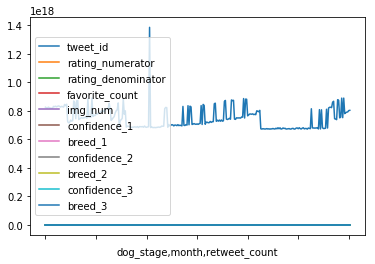

In [91]:
bpsss = df.groupby(['dog_stage','month','retweet_count']).sum().plot(kind='line')